# Redo Marks fitness pred

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score

sys.path.append("../")
from utils import *
from global_variables import *
from escape_map import *
pgm_path = "PGM/"
sys.path.append(pgm_path + "source/")
sys.path.append(pgm_path + "utilities/")
import utilities, Proteins_utils, sequence_logo, plots_utils
import rbm, RBM_utils

E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 2, 'F', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  dmean_v_dw = np.dot(s1.T, V)
E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  mean_V = np.dot(weights, V) / sum_weights
C:\Users\maria\AppData\Roaming\Python\Python312\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Loaded 29 KD vectors
Loaded 2 KD vectors
Loaded 671 KD vectors
Loaded 438 KD vectors


In [2]:
import pandas as pd

train_date = pd.Timestamp("2020-04-01")  # or any date-like



em_path = "../params_by_period_0.03_m1_m8_m8/param_period_"+train_date.strftime("%Y-%m-%d")+".csv"
model=load_escape_map_from_csv(em_path)
seqs=Proteins_utils.load_FASTA('single_variants.fasta', drop_duplicates=False)
scores=-model(seqs)

scores.shape

(1401,)

Test set size = 1401


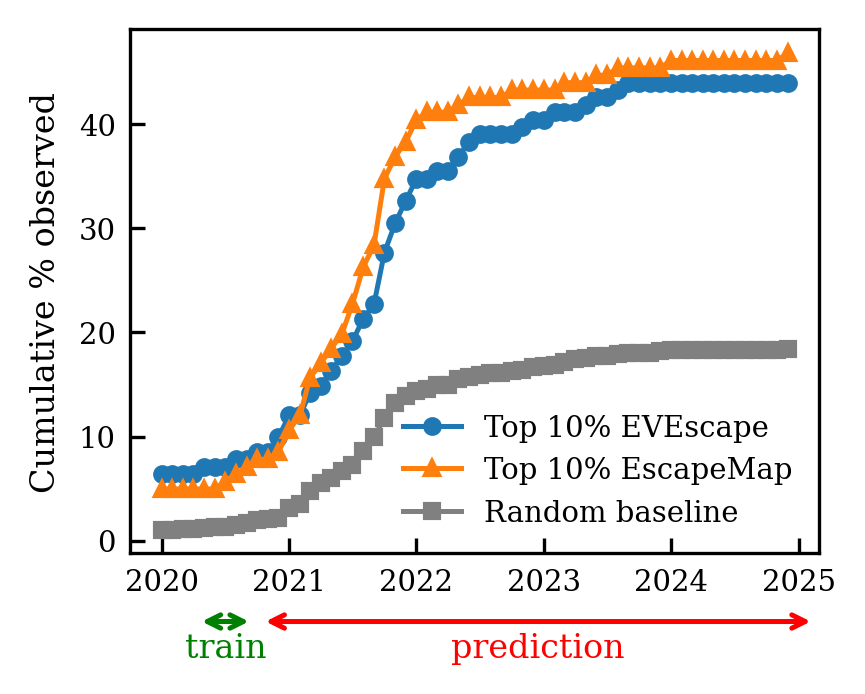

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

# --- Load base ---
df_base = pd.read_csv("rbd_dist_one_scores_gisaid.csv")
df_base = df_base[(df_base['i'] >= 349) & (df_base['i'] <= 526)].copy()
df_base['escapemap'] = scores

df_base['first_seen_100'] = pd.to_datetime(df_base['first_seen_100'], format="%Y-%m", errors="coerce")
df_base.loc[df_base['count'] < 100, 'first_seen_100'] = pd.NaT  # mask low-count dates

th = 90  # percentile threshold

# ---------- Prepare frames (single pass, no seeds) ----------
df = df_base.copy()

# load EscapeMap scores
# col_em = "score" if "score" in df_em.columns else "scores"
df["escapemap"] = scores

print(f"Test set size = {len(df)}")

# thresholds
thr_eve = np.nanpercentile(df["evescape"], th)
thr_em  = np.nanpercentile(df["escapemap"], th)

# subsets (top 100-th % for each scoring scheme)
top_eve = df[df["evescape"]   >= thr_eve].copy()
top_em  = df[df["escapemap"]  >= thr_em].copy()

# drop NaT
with_seen_eve = top_eve.dropna(subset=["first_seen_100"]).copy()
with_seen_em  = top_em.dropna(subset=["first_seen_100"]).copy()

# ---------- Global month axis ----------
mins, maxs = [], []
for x in (with_seen_eve, with_seen_em):
    if not x.empty:
        mins.append(x["first_seen_100"].min())
        maxs.append(x["first_seen_100"].max())

if not mins or not maxs:
    raise RuntimeError("No valid dates found after filtering; check inputs.")

global_start = min(mins)
global_end   = max(maxs)
global_months = pd.date_range(global_start, global_end, freq="MS")

def cum_frac(seen_df, denom, months):
    if denom == 0 or seen_df.empty:
        return np.zeros(len(months), dtype=float)
    dates = np.sort(seen_df["first_seen_100"].to_numpy("datetime64[ns]"))
    months64 = months.to_numpy("datetime64[ns]")
    counts = np.searchsorted(dates, months64, side="right")
    return (counts / denom) * 100.0

# ---------- Curves on common axis ----------
tot_eve, tot_em = len(top_eve), len(top_em)
avg_eve = cum_frac(with_seen_eve, tot_eve, global_months)
avg_em  = cum_frac(with_seen_em,  tot_em,  global_months)

# random: percentage of total mutations that appeared in pandemic
seen_all = df_base.dropna(subset=["first_seen_100"]).copy()
avg_rnd = cum_frac(seen_all, len(df_base), global_months)

# --- Plot (single curves, no seed averaging) ---
mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600,
    "axes.linewidth": 0.8, "lines.linewidth": 1.2, "lines.markersize": 3.5,
    "font.size": 8, "axes.labelsize": 8, "xtick.labelsize": 7, "ytick.labelsize": 7,
    "legend.fontsize": 7, "font.family": "serif", "mathtext.fontset": "stix",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(2.8, 2.0))

ax.plot(global_months, avg_eve, marker="o", label=f"Top {100-th}% EVEscape")
ax.plot(global_months, avg_em,  marker="^", label=f"Top {100-th}% EscapeMap")
ax.plot(global_months, avg_rnd, marker="s", label="Random baseline", color="gray")

# X axis: yearly ticks
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis="x", labelrotation=0)

ax.set_ylabel("Cumulative % observed")
ax.tick_params(direction="in", which="both", top=False, right=False)
ax.legend(frameon=False, loc="best")
fig.tight_layout(pad=0.5)

# --- Train/prediction arrows placed lower ---
x0_num, x1_num = ax.get_xlim()
x0 = mdates.num2date(x0_num)
x1 = mdates.num2date(x1_num)
mid = train_date+pd.DateOffset(months=6)  # extend train arrow 6 months right
x0 = train_date  # extend train arrow 6 months left

y = -0.13
xf = ax.get_xaxis_transform()  # data x, axes-fraction y

ax.annotate("", xy=(mid, y), xytext=(x0, y),
            xycoords=("data", "axes fraction"), textcoords=("data", "axes fraction"),
            arrowprops=dict(arrowstyle="<->", lw=1.2, color="green"), annotation_clip=False)
cx_train = mdates.num2date((mdates.date2num(x0) + mdates.date2num(mid)) / 2)
ax.text(cx_train, y - 0.02, "train", color="green", ha="center", va="top",
        transform=xf, clip_on=False)

ax.annotate("", xy=(x1, y), xytext=(mid, y),
            xycoords=("data", "axes fraction"), textcoords=("data", "axes fraction"),
            arrowprops=dict(arrowstyle="<->", lw=1.2, color="red"), annotation_clip=False)
cx_pred = mdates.num2date((mdates.date2num(mid) + mdates.date2num(x1)) / 2)
ax.text(cx_pred, y - 0.02, "prediction", color="red", ha="center", va="top",
        transform=xf, clip_on=False)

plt.show()


## Scoring of existing mutations

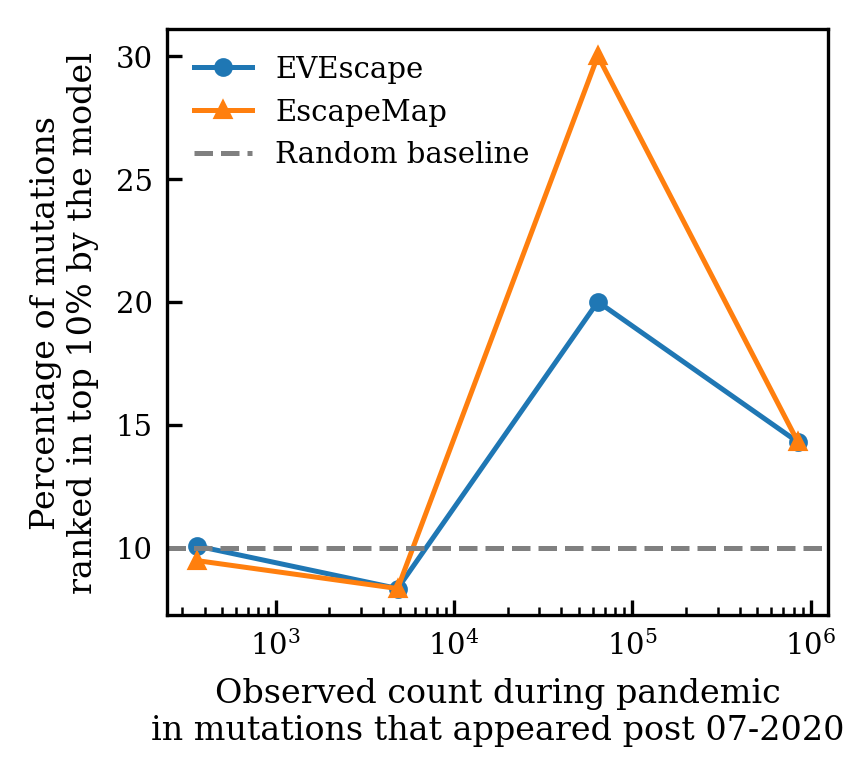

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# ----------------- Params -----------------
NB_EDGES = 5           # number of log-space edges => NB_EDGES-1 bins
th = 90                # percentile threshold (top 5%)

# ----------------- Load & restrict to RBD -----------------
df_base = pd.read_csv("rbd_dist_one_scores_gisaid.csv")
df_base = df_base[(df_base['i'] >= 349) & (df_base['i'] <= 526)].copy()
df_base['first_seen_100'] = pd.to_datetime(df_base['first_seen_100'], format="%Y-%m", errors="coerce")

# Use same EscapeMap data as previous plot
# df_base["escapemap"] = df_em[col_em].values
df_base["escapemap"] = scores
df_base['test'] = np.where(df_base['first_seen_100'] > train_date+pd.DateOffset(months=3), 1, 0)

df_base=df_base[df_base['test']==1]
# Parse first_seen and pandemic window
df_base["first_seen_dt"] = pd.to_datetime(df_base["first_seen_100"], format="%Y-%m", errors="coerce")

pandemic_start = pd.Timestamp("2020-01-01")
pandemic_end   = pd.Timestamp("2026-01-01")  # exclusive
obs = df_base[(df_base["first_seen_dt"] >= pandemic_start) & (df_base["first_seen_dt"] < pandemic_end)].copy()

# ----------------- Build log-spaced frequency bins -----------------
freq = pd.to_numeric(obs["count"], errors="coerce").fillna(0).astype(float)
freq_clip = np.clip(freq.values, 1.0, None)   # clip zeros to 1 for binning

lo, hi = float(freq_clip.min()), float(freq_clip.max())
if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
    raise ValueError("Frequency range invalid; cannot create log bins.")

edges_log = np.linspace(np.log10(lo), np.log10(hi), NB_EDGES)
edges = 10.0 ** edges_log
midpoints = np.sqrt(edges[:-1] * edges[1:])  # geometric mean per bin

# Precompute bin masks for obs
bin_masks = []
for i in range(NB_EDGES - 1):
    left, right = edges[i], edges[i+1]
    if i < NB_EDGES - 2:
        bin_mask = (freq_clip >= left) & (freq_clip < right)
    else:
        bin_mask = (freq_clip >= left) & (freq_clip <= right)
    bin_masks.append(bin_mask)

# ----------------- Helper -----------------
def share_top_decile(values, threshold, base_mask):
    n = int(base_mask.sum())
    if n == 0:
        return np.nan
    return 100.0 * np.sum(values[base_mask] >= threshold) / n

# ----------------- Thresholds on FULL RBD set (seedless) -----------------
thr_eve_global = np.nanpercentile(df_base["evescape"], th)
thr_em_global  = np.nanpercentile(df_base["escapemap"], th)

# Values aligned to obs
eve_vals_obs = df_base.loc[obs.index, "evescape"].values
em_vals_obs  = df_base.loc[obs.index, "escapemap"].values

# ----------------- Per-bin shares (no test mask, no seeds) -----------------
eve_curve = []
em_curve  = []
for bin_mask in bin_masks:
    eve_curve.append(share_top_decile(eve_vals_obs, thr_eve_global, bin_mask))
    em_curve.append( share_top_decile(em_vals_obs,  thr_em_global,  bin_mask))

eve_curve = np.array(eve_curve, dtype=float)
em_curve  = np.array(em_curve,  dtype=float)

# ----------------- Random baseline -----------------
random_baseline = 100 - th  # e.g., 5 for top-5%

# ----------------- Plot -----------------
mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600,
    "axes.linewidth": 0.8, "lines.linewidth": 1.2, "lines.markersize": 3.5,
    "font.size": 8, "axes.labelsize": 8, "xtick.labelsize": 7, "ytick.labelsize": 7,
    "legend.fontsize": 7, "font.family": "serif", "mathtext.fontset": "stix",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(2.8, 2.5))
x = midpoints

line_eve, = ax.plot(x, eve_curve, marker="o", label="EVEscape")
line_em,  = ax.plot(x, em_curve,  marker="^", label="EscapeMap")

ax.axhline(random_baseline, linestyle="--", label="Random baseline", color="grey")

ax.set_xscale("log")
# build the cutoff string in M-AA format
cutoff = (pd.to_datetime(train_date) + pd.DateOffset(months=3)).strftime("%m-%Y")

ax.set_xlabel(f"Observed count during pandemic\nin mutations that appeared post {cutoff}")

# ax.set_ylabel("Top "+str(100-th)+"% share (%)")
ax.set_ylabel(f"Percentage of mutations\nranked in top {100-th}% by the model")
# stop()
ax.tick_params(direction="in", which="both", top=False, right=False)
ax.legend(frameon=False, loc="best")

fig.tight_layout(pad=0.5)
plt.show()


# Ablation  study

scores_full.shape: (1401,)
scores_norbm.shape: (1401,)
Test set size = 1401


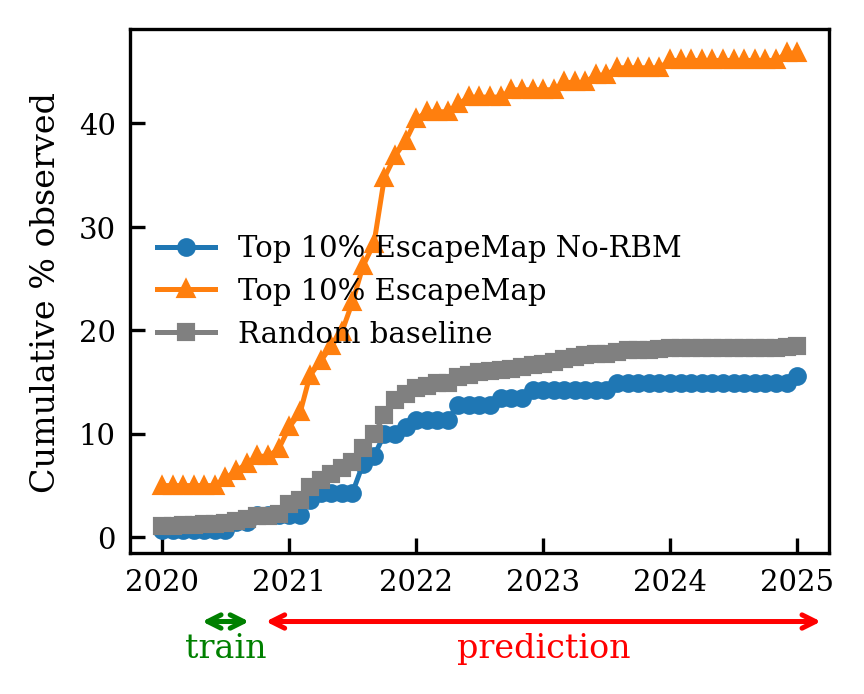

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

# --------- Load model + scores (full and no-RBM) ----------
train_date = pd.Timestamp("2020-04-01")  # or any date-like
em_path = "../params_by_period_0.03_m1_m8_m8/param_period_"+train_date.strftime("%Y-%m-%d")+".csv"

model_full = load_escape_map_from_csv(em_path)
model_norbm = load_escape_map_from_csv(em_path)
model_norbm.raw_beta = -10.0  # suppress RBM viability penalty

seqs = Proteins_utils.load_FASTA('single_variants.fasta', drop_duplicates=False)
scores_full  = -model_full(seqs)
scores_norbm = -model_norbm(seqs)

print("scores_full.shape:", np.shape(scores_full))
print("scores_norbm.shape:", np.shape(scores_norbm))

# --- Load base ---
df_base = pd.read_csv("rbd_dist_one_scores_gisaid.csv")
df_base = df_base[(df_base['i'] >= 349) & (df_base['i'] <= 526)].copy()

# attach scores (order must match seqs)
df_base['escapemap']       = np.asarray(scores_full).ravel()
df_base['escapemap_norbm'] = np.asarray(scores_norbm).ravel()

df_base['first_seen_100'] = pd.to_datetime(df_base['first_seen_100'], format="%Y-%m", errors="coerce")


th = 90  # percentile threshold

# ---------- Prepare frames ----------
df = df_base.copy()

print(f"Test set size = {len(df)}")

# thresholds (top 100-th % for each scoring scheme)
thr_em_full  = np.nanpercentile(df["escapemap"], th)
thr_em_norbm = np.nanpercentile(df["escapemap_norbm"], th)

top_em_full  = df[df["escapemap"]       >= thr_em_full].copy()
top_em_norbm = df[df["escapemap_norbm"] >= thr_em_norbm].copy()

# drop NaT
with_seen_em_full  = top_em_full.dropna(subset=["first_seen_100"]).copy()
with_seen_norbm    = top_em_norbm.dropna(subset=["first_seen_100"]).copy()

# ---------- Global month axis ----------
mins, maxs = [], []
for x in (with_seen_em_full, with_seen_norbm):
    if not x.empty:
        mins.append(x["first_seen_100"].min())
        maxs.append(x["first_seen_100"].max())

if not mins or not maxs:
    raise RuntimeError("No valid dates found after filtering; check inputs.")

global_start = min(mins)
global_end   = max(maxs)
global_months = pd.date_range(global_start, global_end, freq="MS")

def cum_frac(seen_df, denom, months):
    if denom == 0 or seen_df.empty:
        return np.zeros(len(months), dtype=float)
    dates = np.sort(seen_df["first_seen_100"].to_numpy("datetime64[ns]"))
    months64 = months.to_numpy("datetime64[ns]")
    counts = np.searchsorted(dates, months64, side="right")
    return (counts / denom) * 100.0

# ---------- Curves on common axis ----------
tot_full  = len(top_em_full)
tot_norbm = len(top_em_norbm)

avg_full  = cum_frac(with_seen_em_full,  tot_full,  global_months)
avg_norbm = cum_frac(with_seen_norbm,    tot_norbm, global_months)

# random: percentage of total mutations that appeared in pandemic
seen_all = df_base.dropna(subset=["first_seen_100"]).copy()
avg_rnd = cum_frac(seen_all, len(df_base), global_months)

# --- Plot ---
mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600,
    "axes.linewidth": 0.8, "lines.linewidth": 1.2, "lines.markersize": 3.5,
    "font.size": 8, "axes.labelsize": 8, "xtick.labelsize": 7, "ytick.labelsize": 7,
    "legend.fontsize": 7, "font.family": "serif", "mathtext.fontset": "stix",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(2.8, 2.0))

ax.plot(global_months, avg_norbm, marker="o", label=f"Top {100-th}% EscapeMap No-RBM")
ax.plot(global_months, avg_full,  marker="^", label=f"Top {100-th}% EscapeMap")
ax.plot(global_months, avg_rnd,   marker="s", label="Random baseline", color="gray")

# X axis: yearly ticks
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis="x", labelrotation=0)

ax.set_ylabel("Cumulative % observed")
ax.tick_params(direction="in", which="both", top=False, right=False)
ax.legend(frameon=False, loc="best")
fig.tight_layout(pad=0.5)

# --- Train/prediction arrows placed lower (unchanged) ---
x0_num, x1_num = ax.get_xlim()
x0 = mdates.num2date(x0_num)
x1 = mdates.num2date(x1_num)
mid = train_date + pd.DateOffset(months=6)  # extend train arrow 6 months right
x0 = train_date                             # extend train arrow 6 months left

y = -0.13
xf = ax.get_xaxis_transform()  # data x, axes-fraction y

ax.annotate("", xy=(mid, y), xytext=(x0, y),
            xycoords=("data", "axes fraction"), textcoords=("data", "axes fraction"),
            arrowprops=dict(arrowstyle="<->", lw=1.2, color="green"), annotation_clip=False)
cx_train = mdates.num2date((mdates.date2num(x0) + mdates.date2num(mid)) / 2)
ax.text(cx_train, y - 0.02, "train", color="green", ha="center", va="top",
        transform=xf, clip_on=False)

ax.annotate("", xy=(x1, y), xytext=(mid, y),
            xycoords=("data", "axes fraction"), textcoords=("data", "axes fraction"),
            arrowprops=dict(arrowstyle="<->", lw=1.2, color="red"), annotation_clip=False)
cx_pred = mdates.num2date((mdates.date2num(mid) + mdates.date2num(x1)) / 2)
ax.text(cx_pred, y - 0.02, "prediction", color="red", ha="center", va="top",
        transform=xf, clip_on=False)

plt.show()


In [6]:
import re, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

# ------------------ config ------------------
EM_DIR = "../params_by_period_0.03_m1_m8_m8"
FIRST_PERIOD = pd.Timestamp("2020-01-01")
TOP_PCT = 0.1          # top 10%
HORIZON_MONTHS = 3      # "next period" = next 3 months

def parse_period_from_name(p):
    m = re.search(r"param_period_([0-9]{4}-[0-9]{2}-[0-9]{2})\.csv$", p)
    if not m:
        return None
    return pd.to_datetime(m.group(1), format="%Y-%m-%d", errors="coerce")

def list_available_periods(em_dir=EM_DIR, min_date=None):
    files = glob.glob(f"{em_dir}/param_period_*.csv")
    periods = sorted([parse_period_from_name(f) for f in files if parse_period_from_name(f) is not None])
    if min_date is not None:
        periods = [p for p in periods if p >= min_date]
    return periods

# Ensure seqs exist
try:
    seqs
except NameError:
    seqs = Proteins_utils.load_FASTA("single_variants.fasta", drop_duplicates=False)

# Build period list
time_periods = list_available_periods(EM_DIR, min_date=FIRST_PERIOD)
if len(time_periods) < 2:
    raise RuntimeError("Need at least two periods (train + next test period) in EM_DIR.")

# Results per period
rows = []

for train_date in time_periods[:-1]:
    em_path = f"{EM_DIR}/param_period_{train_date.strftime('%Y-%m-%d')}.csv"
    test_start = train_date + pd.DateOffset(months=3)
    test_end   = test_start + pd.DateOffset(months=HORIZON_MONTHS)  # next 3 months

    # Load models
    model_full  = load_escape_map_from_csv(em_path)
    model_norbm = load_escape_map_from_csv(em_path)
    model_norbm.raw_beta = -10.0  # disable RBM viability term

    # Score all single mutants (same order as df_base is expected)
    scores_full  = -model_full(seqs)
    scores_norbm = -model_norbm(seqs)

    # Base table
    df = pd.read_csv("rbd_dist_one_scores_gisaid.csv")
    df = df[(df['i'] >= 349) & (df['i'] <= 526)].copy()
    df['first_seen_100'] = pd.to_datetime(df['first_seen_100'], format="%Y-%m", errors="coerce")
    if "count" in df.columns:
        df.loc[df['count'] < 100, 'first_seen_100'] = pd.NaT  # mask low-count dates

    # Attach scores (must align 1:1 with df rows)
    assert len(df) == len(scores_full) == len(scores_norbm), "Score/row length mismatch."
    df["score_full"]  = np.asarray(scores_full).ravel()
    df["score_norbm"] = np.asarray(scores_norbm).ravel()

    # Candidates: not seen before next period start
    cand = df[df['first_seen_100'].isna() | (df['first_seen_100'] >= test_start)].copy()

    # Label: appears in [test_start, test_end)
    appears_next = cand['first_seen_100'].ge(test_start) & cand['first_seen_100'].lt(test_end)

    # For each model, take top K among candidates, compute fraction that appear_next
    def frac_topK_appear(score_col):
        if cand.empty:
            return np.nan, 0, 0, 0
        k = int(np.ceil(len(cand) * TOP_PCT))
        if k == 0:
            return np.nan, len(cand), 0, 0
        idx_top = cand[score_col].nlargest(k).index
        pos = appears_next.loc[idx_top]
        return float(pos.mean()) * 100.0, len(cand), k, int(pos.sum())

    pct_full, n_cand, k_full, n_pos_full = frac_topK_appear("score_full")
    pct_norbm, _,      k_nr,   n_pos_nr  = frac_topK_appear("score_norbm")

    # Optional random baseline: same K, but random picks among candidates
    rnd_pct = np.nan
    if n_cand and k_full:
        rnd_sel = np.random.default_rng(0).choice(cand.index.to_numpy(), size=k_full, replace=False)
        rnd_pct = appears_next.loc[rnd_sel].mean() * 100.0

    rows.append({
        "train_date": train_date,
        "test_window_start": test_start,
        "test_window_end": test_end,
        "pct_top10_full": pct_full,
        "pct_top10_norbm": pct_norbm,
        "pct_top10_random": rnd_pct,
        "n_candidates": n_cand,
        "k_top": k_full,
        "n_pos_full_in_top": n_pos_full,
        "n_pos_norbm_in_top": n_pos_nr
    })

# Assemble results
res = pd.DataFrame(rows).sort_values("train_date").reset_index(drop=True)
print(res[["train_date","pct_top10_full","pct_top10_norbm","pct_top10_random","n_candidates","k_top"]])



   train_date  pct_top10_full  pct_top10_norbm  pct_top10_random  \
0  2020-01-01        0.000000         0.000000          0.000000   
1  2020-04-01        2.158273         0.719424          0.719424   
2  2020-07-01        1.449275         1.449275          0.724638   
3  2020-10-01        7.299270         1.459854          3.649635   
4  2021-01-01        5.223881         0.746269          2.238806   
5  2021-04-01       11.450382         3.053435          2.290076   
6  2021-07-01       13.385827         6.299213          3.149606   
7  2021-10-01        4.132231         1.652893          0.000000   
8  2022-01-01        2.500000         3.333333          0.833333   
9  2022-04-01        1.680672         2.521008          1.680672   
10 2022-07-01        3.389831         3.389831          0.847458   
11 2022-10-01        0.854701         0.000000          0.000000   
12 2023-01-01        0.862069         0.862069          0.000000   
13 2023-04-01        2.586207         1.724138  

C:\Users\maria\AppData\Local\Temp\ipykernel_7240\2663304222.py:7: RuntimeWarning: divide by zero encountered in divide
  enr_full  = np.asarray(res["pct_top10_full"],   dtype=float)  / np.asarray(res["pct_top10_random"], dtype=float)
C:\Users\maria\AppData\Local\Temp\ipykernel_7240\2663304222.py:7: RuntimeWarning: invalid value encountered in divide
  enr_full  = np.asarray(res["pct_top10_full"],   dtype=float)  / np.asarray(res["pct_top10_random"], dtype=float)
C:\Users\maria\AppData\Local\Temp\ipykernel_7240\2663304222.py:8: RuntimeWarning: divide by zero encountered in divide
  enr_nrbm  = np.asarray(res["pct_top10_norbm"],  dtype=float)  / np.asarray(res["pct_top10_random"], dtype=float)
C:\Users\maria\AppData\Local\Temp\ipykernel_7240\2663304222.py:8: RuntimeWarning: invalid value encountered in divide
  enr_nrbm  = np.asarray(res["pct_top10_norbm"],  dtype=float)  / np.asarray(res["pct_top10_random"], dtype=float)


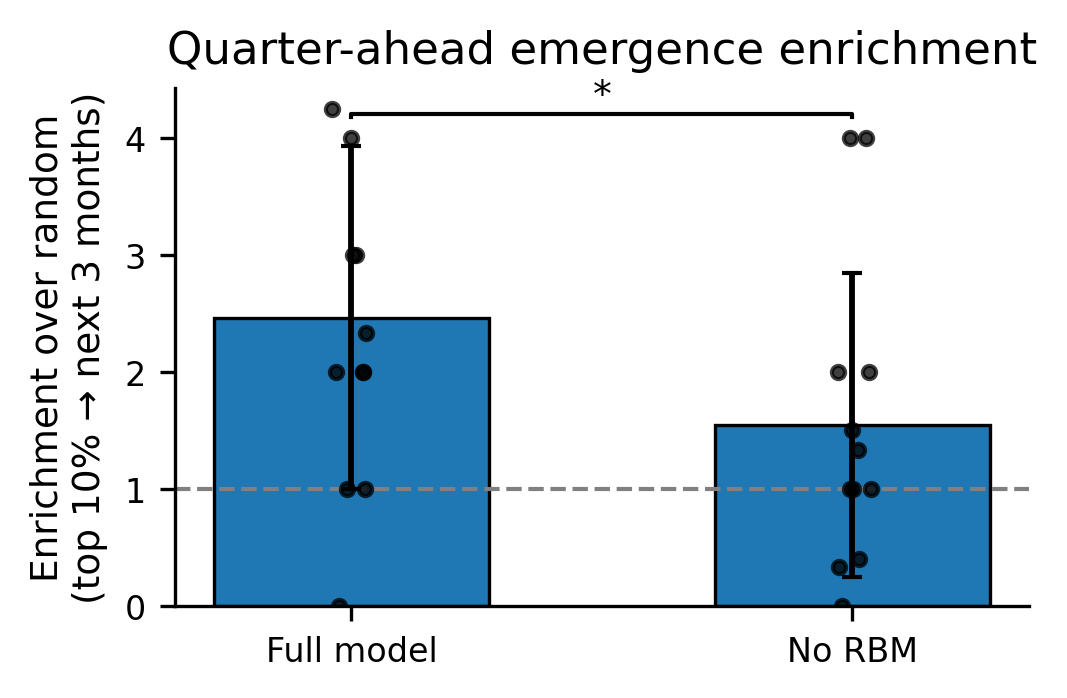

n paired periods = 12
Full   enrichment: mean±SD = 2.47× ± 1.46×
NoRBM  enrichment: mean±SD = 1.55× ± 1.30×
Paired t-test (Full vs NoRBM): p = 0.0427


In [7]:
# ----- Enrichment: model / random (per period) -----
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

# Use ratios (percent cancels): enrichment = pct_model / pct_random
enr_full  = np.asarray(res["pct_top10_full"],   dtype=float)  / np.asarray(res["pct_top10_random"], dtype=float)
enr_nrbm  = np.asarray(res["pct_top10_norbm"],  dtype=float)  / np.asarray(res["pct_top10_random"], dtype=float)

# Keep only paired finite periods with random>0
m = np.isfinite(enr_full) & np.isfinite(enr_nrbm) & (np.asarray(res["pct_top10_random"]) > 0)
enr_full_p, enr_nrbm_p = enr_full[m], enr_nrbm[m]

# --- Summary stats ---
def mean_sd(x):
    x = x[np.isfinite(x)]
    if x.size == 0: return np.nan, 0.0
    mu = float(np.nanmean(x))
    sd = float(np.nanstd(x, ddof=1)) if x.size > 1 else 0.0
    return mu, sd

mu_full,  sd_full  = mean_sd(enr_full_p)
mu_nrbm,  sd_nrbm  = mean_sd(enr_nrbm_p)

# Paired t-test on enrichments
pval = ttest_rel(enr_full_p, enr_nrbm_p).pvalue if (enr_full_p.size and enr_nrbm_p.size) else np.nan

# --- Plot: bars with jitter, line at 1×, significance bracket ---
try:
    nature_rc()
except Exception:
    plt.rcParams.update({
        "figure.dpi": 300, "savefig.dpi": 600,
        "axes.linewidth": 0.8, "lines.linewidth": 1.4,
        "font.size": 9, "axes.labelsize": 9, "xtick.labelsize": 8, "ytick.labelsize": 8,
        "legend.fontsize": 8, "font.family": "sans-serif",
    })

def star_for_p(pv: float) -> str:
    if not np.isfinite(pv): return "n.s."
    if pv < 1e-3: return "***"
    if pv < 1e-2: return "**"
    if pv < 5e-2: return "*"
    return "n.s."

def annotate_sig(ax, x1, x2, y, pval, h=0.03):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.0, color="black")
    ax.text((x1+x2)/2, y+h, star_for_p(pval), ha="center", va="bottom")

fig, ax = plt.subplots(figsize=(3.6, 2.4))
x = np.array([0, 1])  # Full, No-RBM
means = [mu_full, mu_nrbm]
errs  = [sd_full, sd_nrbm]

bars = ax.bar(x, means, yerr=errs, capsize=2.5, width=0.55,
              edgecolor="black", linewidth=0.8)
bars[0].set_label("Full")
bars[1].set_label("No RBM")

# Jittered per-period points
rng = np.random.default_rng(42)
def jitter(center, n): return rng.normal(loc=center, scale=0.03, size=n)
ax.scatter(jitter(x[0], enr_full_p.size), enr_full_p,  s=10, alpha=0.75, color="black", zorder=3)
ax.scatter(jitter(x[1], enr_nrbm_p.size), enr_nrbm_p, s=10, alpha=0.75, color="black", zorder=3)

# Grey horizontal line at 1× (random)
ax.axhline(1.0, color="gray", linewidth=1.0, linestyle="--", zorder=1)

# Axes & styling
ax.set_xticks(x, ["Full model", "No RBM"])
ax.set_ylabel("Enrichment over random\n(top 10% → next 3 months)")
# y-limits: accommodate bars/points and the bracket
y_top = max(1.05, np.nanmax(means) + (np.nanmax(errs) if np.isfinite(np.nanmax(errs)) else 0) + 0.1)
ax.set_ylim(0, y_top+0.4)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Quarter-ahead emergence enrichment")

# Significance bracket between Full and No-RBM
annotate_sig(ax, x1=x[0], x2=x[1], y=min(y_top-0.05, max(means)+max(errs)+0.05)+0.2, pval=pval)

plt.tight_layout()
plt.show()

print(f"n paired periods = {enr_full_p.size}")
print(f"Full   enrichment: mean±SD = {mu_full:.2f}× ± {sd_full:.2f}×")
print(f"NoRBM  enrichment: mean±SD = {mu_nrbm:.2f}× ± {sd_nrbm:.2f}×")
print(f"Paired t-test (Full vs NoRBM): p = {pval:.3g}")


# Predict mutations present in each period

In [10]:
import re
import glob
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Tuple




# ------------------ Configuration ------------------
EM_DIR = "../params_by_period_0.03_m1_m8_m8"
FASTA_FILE = "../seq_data/WT_single_mutants.fasta"
OUTPUT_CSV = "wt_mutation_scores_by_period.csv"
FIRST_PERIOD = pd.Timestamp("2020-01-01")

# Regex to parse mutation name (e.g., "BQ_M349A")
RE_MUT_NAME = re.compile(r".*_([A-Z\*]\d+[A-Z\*])$")
# ---------------------------------------------------


def parse_period_from_name(p: str) -> pd.Timestamp | None:
    """Parses a YYYY-MM-DD date from a parameter file path."""
    m = re.search(r"param_period_([0-9]{4}-[0-9]{2}-[0-9]{2})\.csv$", p)
    if not m:
        return None
    return pd.to_datetime(m.group(1), format="%Y-%m-%d", errors="coerce")


def list_available_periods(em_dir: str, min_date: pd.Timestamp = None) -> List[pd.Timestamp]:
    """Finds all valid, sorted parameter file dates in a directory."""
    files = glob.glob(f"{em_dir}/param_period_*.csv")
    periods = sorted(
        [
            parse_period_from_name(f)
            for f in files
            if parse_period_from_name(f) is not None
        ]
    )
    if min_date is not None:
        periods = [p for p in periods if p >= min_date]
    print(
        f"Found {len(periods)} model periods from {min_date.date()} in {em_dir}"
    )
    return periods


def load_fasta_lists(filepath: str) -> Tuple[List[str], List[str]]:
    """
    Loads a FASTA file, preserving order.
    
    Returns:
        Tuple[List[str], List[str]]: (list_of_headers, list_of_sequences)
    """
    headers: List[str] = []
    sequences: List[str] = []
    current_seq_parts: List[str] = []
    
    try:
        with open(filepath, "r") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                if line.startswith(">"):
                    # Save previous sequence
                    if current_seq_parts:
                        sequences.append("".join(current_seq_parts))
                    
                    # Start new sequence
                    headers.append(line[1:])  # Remove ">"
                    current_seq_parts = []
                else:
                    current_seq_parts.append(line)
        
        # Add the very last sequence
        if current_seq_parts:
            sequences.append("".join(current_seq_parts))
            
    except FileNotFoundError:
        print(f"Error: FASTA file not found at {filepath}")
        return [], []
    except Exception as e:
        print(f"Error reading FASTA file: {e}")
        return [], []

    if len(headers) != len(sequences):
        print(
            f"Warning: Mismatch in FASTA file. Found {len(headers)} headers but {len(sequences)} sequences."
        )
        # Truncate to shortest list
        min_len = min(len(headers), len(sequences))
        return headers[:min_len], sequences[:min_len]

    print(f"Loaded {len(headers)} sequences from {filepath}")
    return headers, sequences


def parse_mutation_names(headers: List[str]) -> List[str]:
    """Extracts mutation names (e.g., M349A) from FASTA headers."""
    parsed_names: List[str] = []
    for h in headers:
        m = RE_MUT_NAME.match(h)
        if m:
            parsed_names.append(m.group(1))
        else:
            print(f"Warning: Could not parse mutation name from header: {h}")
            parsed_names.append(h)  # Use full header as fallback
    return parsed_names


def main():
    # --- 1. Load Sequences and Mutation Names ---
    # These are assumed to be in the correct, corresponding order
    fasta_headers, fasta_sequences = load_fasta_lists(FASTA_FILE)
    if not fasta_headers:
        return  # Error already printed by loader

    # Get the clean mutation names (e.g., "M349A")
    mutation_names = parse_mutation_names(fasta_headers)

    # --- 2. Find all model periods ---
    time_periods = list_available_periods(EM_DIR, min_date=FIRST_PERIOD)
    if not time_periods:
        print(f"No model periods found in {EM_DIR}. Exiting.")
        return

    # --- 3. Score all mutants for each period ---
    all_results: List[dict] = []

    for period_date in time_periods:
        period_str = period_date.strftime("%Y-%m-%d")
        print(f"Processing period: {period_str}...")
        
        em_path = f"{EM_DIR}/param_period_{period_str}.csv"
        
        try:
            # Load models
            model_full = load_escape_map_from_csv(em_path)
            model_norbm = load_escape_map_from_csv(em_path)
            model_norbm.raw_beta = -10.0  # disable RBM viability term
        except Exception as e:
            print(f"  Error loading model from {em_path}: {e}")
            print(f"  Skipping this period.")
            continue

        # Score all single mutants (seqs are passed as a list)
        # We use a negative sign as shown in the inspiration code
        fasta_sequences=Proteins_utils.load_FASTA(FASTA_FILE, drop_duplicates=False)
        try:
            scores_full = -model_full(fasta_sequences)
            scores_norbm = -model_norbm(fasta_sequences)
        except Exception as e:
            print(f"  Error while scoring sequences for period {period_str}: {e}")
            print(f"  Skipping this period.")
            continue
            
        # Ensure scores are 1D arrays
        scores_full = np.asarray(scores_full).ravel()
        scores_norbm = np.asarray(scores_norbm).ravel()

        if len(scores_full) != len(mutation_names):
            print(f"  Error: Score count ({len(scores_full)}) does not match")
            print(f"  sequence count ({len(mutation_names)}). Skipping period.")
            continue

        # Append results for this period
        for i, mut_name in enumerate(mutation_names):
            all_results.append(
                {
                    "mutation": mut_name,
                    "period": period_str,
                    "model_score": scores_full[i],
                    "model_score_without_rbm": scores_norbm[i],
                }
            )

    if not all_results:
        print("No results were generated. Check for errors above.")
        return

    # --- 4. Save to CSV ---
    out_df = pd.DataFrame(all_results)
    
    # Ensure correct column order
    out_df = out_df[["mutation", "period", "model_score", "model_score_without_rbm"]]
    
    try:
        out_df.to_csv(OUTPUT_CSV, index=False)
        print(
            f"\nSuccessfully wrote {len(out_df)} rows to {Path(OUTPUT_CSV).resolve()}"
        )
    except Exception as e:
        print(f"\nError writing output CSV to {OUTPUT_CSV}: {e}")


if __name__ == "__main__":
    main()


Loaded 3382 sequences from ../seq_data/WT_single_mutants.fasta
Found 23 model periods from 2020-01-01 in ../params_by_period_0.03_m1_m8_m8
Processing period: 2020-01-01...
Processing period: 2020-04-01...
Processing period: 2020-07-01...
Processing period: 2020-10-01...
Processing period: 2021-01-01...
Processing period: 2021-04-01...
Processing period: 2021-07-01...
Processing period: 2021-10-01...
Processing period: 2022-01-01...
Processing period: 2022-04-01...
Processing period: 2022-07-01...
Processing period: 2022-10-01...
Processing period: 2023-01-01...
Processing period: 2023-04-01...
Processing period: 2023-07-01...
Processing period: 2023-10-01...
Processing period: 2024-01-01...
Processing period: 2024-04-01...
Processing period: 2024-07-01...
Processing period: 2024-10-01...
Processing period: 2025-01-01...
Processing period: 2025-04-01...
Processing period: 2025-07-01...

Successfully wrote 77786 rows to E:\ESCAPE_MAP_DRAFT\Figure 1 2 (Fitness)\wt_mutation_scores_by_perio

Found 23 common periods for analysis.
Predicting 2020-04-01 using scores from 2020-01-01...
  AUC Full: 0.797, AUC NoRBM: 0.667
Predicting 2020-07-01 using scores from 2020-04-01...
  AUC Full: 0.752, AUC NoRBM: 0.695
Predicting 2020-10-01 using scores from 2020-07-01...
  AUC Full: 0.733, AUC NoRBM: 0.755
Predicting 2021-01-01 using scores from 2020-10-01...
  AUC Full: 0.747, AUC NoRBM: 0.718
Predicting 2021-04-01 using scores from 2021-01-01...
  AUC Full: 0.741, AUC NoRBM: 0.725
Predicting 2021-07-01 using scores from 2021-04-01...
  AUC Full: 0.794, AUC NoRBM: 0.741
Predicting 2021-10-01 using scores from 2021-07-01...
  AUC Full: 0.782, AUC NoRBM: 0.741
Predicting 2022-01-01 using scores from 2021-10-01...
  AUC Full: 0.822, AUC NoRBM: 0.752
Predicting 2022-04-01 using scores from 2022-01-01...
  AUC Full: 0.792, AUC NoRBM: 0.776
Predicting 2022-07-01 using scores from 2022-04-01...
  AUC Full: 0.806, AUC NoRBM: 0.792
Predicting 2022-10-01 using scores from 2022-07-01...
  AUC Fu

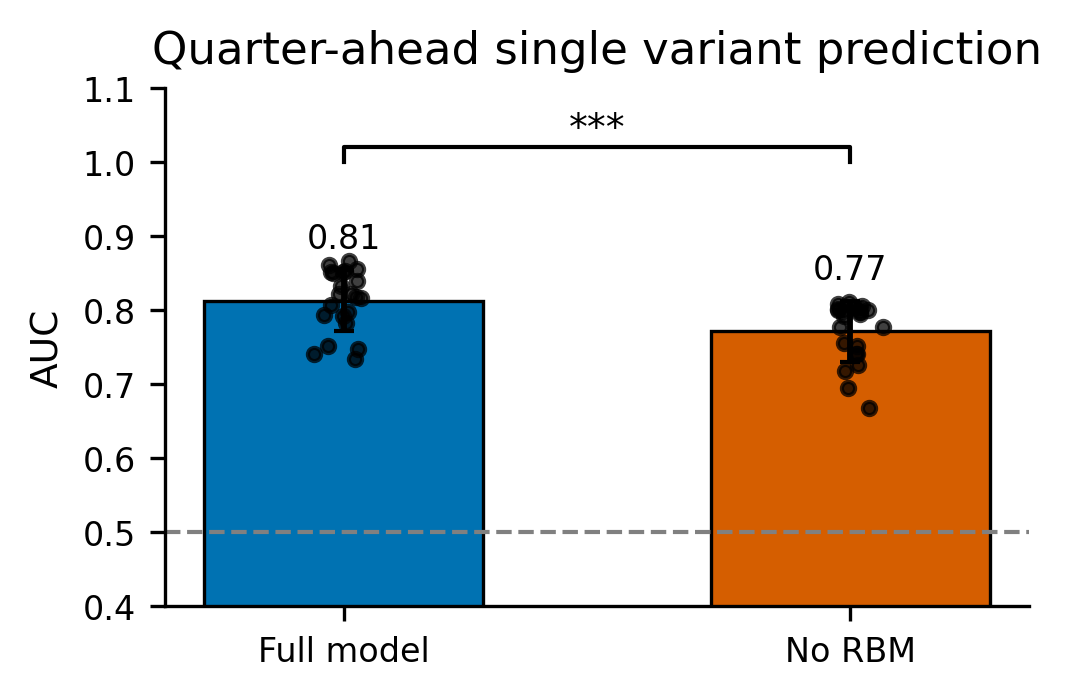


--- Evaluation Summary ---
n paired periods evaluated = 22
Full model AUC: mean±SD = 0.813 ± 0.041
NoRBM model AUC: mean±SD = 0.771 ± 0.041
Paired t-test (Full vs NoRBM): p = 1.72e-06


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from sklearn.metrics import roc_auc_score
from pathlib import Path

# --- Configuration ---
LABELS_CSV = "../seq_data/all_mutations_by_period_status.csv"
SCORES_CSV = "wt_mutation_scores_by_period.csv"

# --- Plotting Functions (from example) ---

def nature_rc():
    """Set some nice matplotlib defaults"""
    plt.rcParams.update({
        "figure.dpi": 300, "savefig.dpi": 600,
        "axes.linewidth": 0.8, "lines.linewidth": 1.4,
        "font.size": 9, "axes.labelsize": 9, "xtick.labelsize": 8, "ytick.labelsize": 8,
        "legend.fontsize": 8, "font.family": "sans-serif",
    })

def star_for_p(pv: float) -> str:
    """Get significance stars for a p-value."""
    if not np.isfinite(pv): return "n.s."
    if pv < 1e-3: return "***"
    if pv < 1e-2: return "**"
    if pv < 5e-2: return "*"
    return "n.s."

def annotate_sig(ax, x1, x2, y, pval, h=0.03):
    """Draw a significance bracket on the axes."""
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.0, color="black")
    ax.text((x1+x2)/2, y+h, star_for_p(pval), ha="center", va="bottom")

def mean_sd(x):
    """Calculate mean and standard deviation for a list of values."""
    x = x[np.isfinite(x)]
    if x.size == 0: return np.nan, 0.0
    mu = float(np.nanmean(x))
    sd = float(np.nanstd(x, ddof=1)) if x.size > 1 else 0.0
    return mu, sd
# ----------------------------------------


def main():
    # --- 1. Load Data ---
    try:
        df_labels = pd.read_csv(LABELS_CSV)
        df_scores = pd.read_csv(SCORES_CSV)
    except FileNotFoundError as e:
        print(f"Error: Could not find input file. {e}")
        print("Please make sure both CSV files are in the same directory.")
        return
    except Exception as e:
        print(f"Error reading CSVs: {e}")
        return

    # --- 2. Find Common, Sorted Periods ---
    label_periods = set(df_labels['period'])
    score_periods = set(df_scores['period'])
    common_periods = sorted(list(label_periods & score_periods))
    
    if len(common_periods) < 2:
        print("Error: Need at least 2 common periods (one for scores, one for labels) to evaluate.")
        return

    print(f"Found {len(common_periods)} common periods for analysis.")

    # --- 3. Calculate AUC for each prediction window ---
    aucs_full = []
    aucs_norbm = []
    prediction_periods = []

    # Iterate from the *second* period, using the *first* as scores
    for i in range(1, len(common_periods)):
        score_period = common_periods[i-1]
        label_period = common_periods[i]

        print(f"Predicting {label_period} using scores from {score_period}...")

        # Get scores from the *previous* period
        scores_now = df_scores[
            df_scores['period'] == score_period
        ]
        # Drop 'period' column to avoid conflict, then set index
        scores_now = scores_now[
            ['mutation', 'model_score', 'model_score_without_rbm']
        ].set_index('mutation')
        
        # Get labels from the *next* period
        labels_next = df_labels[
            df_labels['period'] == label_period
        ].set_index('mutation')

        # Merge to align scores and labels
        df_merged = labels_next.join(scores_now, how='inner')
        df_merged = df_merged.dropna(subset=['appeared_100', 'model_score', 'model_score_without_rbm'])

        if df_merged.empty:
            print("  No overlapping mutations found. Skipping.")
            continue
            
        labels = df_merged['appeared_100']
        
        # Check if we have both positive and negative labels
        if len(labels.unique()) < 2:
            print(f"  Only one class (0 or 1) present in labels for {label_period}. Skipping AUC calculation.")
            continue

        # Calculate AUC for both models
        try:
            auc_full = roc_auc_score(labels, df_merged['model_score'])
            auc_norbm = roc_auc_score(labels, df_merged['model_score_without_rbm'])
            
            aucs_full.append(auc_full)
            aucs_norbm.append(auc_norbm)
            prediction_periods.append(label_period)
            print(f"  AUC Full: {auc_full:.3f}, AUC NoRBM: {auc_norbm:.3f}")

        except Exception as e:
            print(f"  Error calculating AUC for period {label_period}: {e}")

    if not aucs_full:
        print("No valid AUC scores were calculated. Exiting.")
        return

    # --- 4. Statistical Analysis ---
    aucs_full_np = np.asarray(aucs_full)
    aucs_norbm_np = np.asarray(aucs_norbm)

    mu_full,  sd_full  = mean_sd(aucs_full_np)
    mu_nrbm,  sd_nrbm  = mean_sd(aucs_norbm_np)

    # Paired t-test on AUCs
    pval = np.nan
    if aucs_full_np.size > 1 and aucs_norbm_np.size > 1:
        try:
            pval = ttest_rel(aucs_full_np, aucs_norbm_np).pvalue
        except Exception as e:
            print(f"Could not perform t-test: {e}")

    # --- 5. Plotting ---
    try:
        nature_rc()
    except Exception:
        print("nature_rc() not found. Using default matplotlib styles.")

    fig, ax = plt.subplots(figsize=(3.6, 2.4))
    x = np.array([0, 1])  # Full, No-RBM
    means = [mu_full, mu_nrbm]
    errs  = [sd_full, sd_nrbm]

    bars = ax.bar(x, means, yerr=errs, capsize=2.5, width=0.55,
                  edgecolor="black", linewidth=0.8, color=["#0072B2", "#D55E00"])
    bars[0].set_label("Full Model")
    bars[1].set_label("No RBM")

    # Jittered per-period points
    rng = np.random.default_rng(42)
    def jitter(center, n): return rng.normal(loc=center, scale=0.03, size=n)
    
    ax.scatter(jitter(x[0], aucs_full_np.size), aucs_full_np,
               s=10, alpha=0.75, color="black", zorder=3)
    ax.scatter(jitter(x[1], aucs_norbm_np.size), aucs_norbm_np,
               s=10, alpha=0.75, color="black", zorder=3)

    # Grey horizontal line at 0.5 (random guessing for AUC)
    ax.axhline(0.5, color="gray", linewidth=1.0, linestyle="--", zorder=1)

    # Axes & styling
    ax.set_xticks(x, ["Full model", "No RBM"])
    ax.set_ylabel("AUC")
    
    # y-limits: accommodate bars/points and the bracket
    y_top = max(1.0, np.nanmax(means) + (np.nanmax(errs) if np.isfinite(np.nanmax(errs)) else 0) + 0.05)
    ax.set_ylim(0.4, y_top + 0.1) # Start y-axis at 0.4
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_title("Quarter-ahead single variant prediction")
    for i in range(len(x)):
        ax.text(x[i], means[i] + errs[i] + 0.02, f"{means[i]:.2f}", ha='center', va='bottom', fontsize=8)
        
    # Significance bracket between Full and No-RBM
    annotate_sig(ax, x1=x[0], x2=x[1], y=y_top, pval=pval, h=0.02)

    plt.tight_layout()

    plt.show()

    # --- 6. Print Final Stats ---
    print(f"\n--- Evaluation Summary ---")
    print(f"n paired periods evaluated = {aucs_full_np.size}")
    print(f"Full model AUC: mean±SD = {mu_full:.3f} ± {sd_full:.3f}")
    print(f"NoRBM model AUC: mean±SD = {mu_nrbm:.3f} ± {sd_nrbm:.3f}")
    print(f"Paired t-test (Full vs NoRBM): p = {pval:.3g}")


if __name__ == "__main__":
    main()



Found 23 common periods for analysis.
Predicting 2020-04-01 using scores from 2020-01-01...
  Site-level AUC Full: 0.704, AUC NoRBM: 0.658
Predicting 2020-07-01 using scores from 2020-04-01...
  Site-level AUC Full: 0.710, AUC NoRBM: 0.667
Predicting 2020-10-01 using scores from 2020-07-01...
  Site-level AUC Full: 0.748, AUC NoRBM: 0.758
Predicting 2021-01-01 using scores from 2020-10-01...
  Site-level AUC Full: 0.777, AUC NoRBM: 0.696
Predicting 2021-04-01 using scores from 2021-01-01...
  Site-level AUC Full: 0.789, AUC NoRBM: 0.716
Predicting 2021-07-01 using scores from 2021-04-01...
  Site-level AUC Full: 0.725, AUC NoRBM: 0.696
Predicting 2021-10-01 using scores from 2021-07-01...
  Site-level AUC Full: 0.743, AUC NoRBM: 0.724
Predicting 2022-01-01 using scores from 2021-10-01...
  Site-level AUC Full: 0.756, AUC NoRBM: 0.727
Predicting 2022-04-01 using scores from 2022-01-01...
  Site-level AUC Full: 0.766, AUC NoRBM: 0.740
Predicting 2022-07-01 using scores from 2022-04-01...

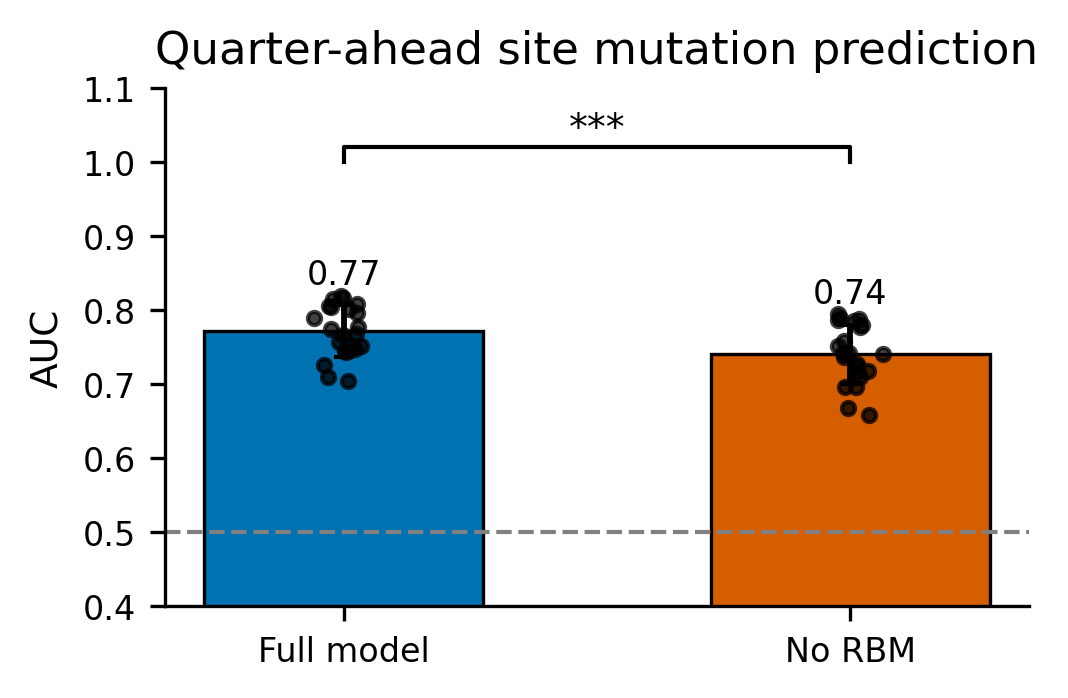


--- Evaluation Summary ---
n paired periods evaluated = 22
Full model AUC: mean±SD = 0.771 ± 0.035
NoRBM model AUC: mean±SD = 0.740 ± 0.040
Paired t-test (Full vs NoRBM): p = 3.71e-07


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from sklearn.metrics import roc_auc_score
from pathlib import Path

# --- Configuration ---

MIN_EMERGED_MUTATIONS_FOR_LABEL = 1

# --- Plotting Functions (from example) ---

def nature_rc():
    """Set some nice matplotlib defaults"""
    plt.rcParams.update({
        "figure.dpi": 300, "savefig.dpi": 600,
        "axes.linewidth": 0.8, "lines.linewidth": 1.4,
        "font.size": 9, "axes.labelsize": 9, "xtick.labelsize": 8, "ytick.labelsize": 8,
        "legend.fontsize": 8, "font.family": "sans-serif",
    })

def star_for_p(pv: float) -> str:
    """Get significance stars for a p-value."""
    if not np.isfinite(pv): return "n.s."
    if pv < 1e-3: return "***"
    if pv < 1e-2: return "**"
    if pv < 5e-2: return "*"
    return "n.s."

def annotate_sig(ax, x1, x2, y, pval, h=0.03):
    """Draw a significance bracket on the axes."""
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.0, color="black")
    ax.text((x1+x2)/2, y+h, star_for_p(pval), ha="center", va="bottom")

def mean_sd(x):
    """Calculate mean and standard deviation for a list of values."""
    x = x[np.isfinite(x)]
    if x.size == 0: return np.nan, 0.0
    mu = float(np.nanmean(x))
    sd = float(np.nanstd(x, ddof=1)) if x.size > 1 else 0.0
    return mu, sd
# ----------------------------------------

def extract_site(df):
    """Helper to extract site number from mutation string."""
    df['site'] = pd.to_numeric(
        df['mutation'].str.extract(r'(\d+)')[0], errors='coerce'
    )
    df = df.dropna(subset=['site'])
    df['site'] = df['site'].astype(int)
    return df

def main():
    # --- 1. Load Data ---
    try:
        df_labels = pd.read_csv(LABELS_CSV)
        df_scores = pd.read_csv(SCORES_CSV)
    except FileNotFoundError as e:
        print(f"Error: Could not find input file. {e}")
        print("Please make sure both CSV files are in the same directory.")
        return
    except Exception as e:
        print(f"Error reading CSVs: {e}")
        return

    # --- 2. Find Common, Sorted Periods ---
    label_periods = set(df_labels['period'])
    score_periods = set(df_scores['period'])
    common_periods = sorted(list(label_periods & score_periods))
    
    if len(common_periods) < 2:
        print("Error: Need at least 2 common periods (one for scores, one for labels) to evaluate.")
        return

    print(f"Found {len(common_periods)} common periods for analysis.")

    # --- 3. Calculate AUC for each prediction window ---
    aucs_full = []
    aucs_norbm = []
    prediction_periods = []

    # Iterate from the *second* period, using the *first* as scores
    for i in range(1, len(common_periods)):
        score_period = common_periods[i-1]
        label_period = common_periods[i]

        print(f"Predicting {label_period} using scores from {score_period}...")

        # --- A: Process Scores (Predictors) from previous period ---
        scores_now_df = df_scores[df_scores['period'] == score_period].copy()
        scores_now_df = extract_site(scores_now_df)
        
        # Calculate average score per site
        site_scores = scores_now_df.groupby('site')[
            ['model_score', 'model_score_without_rbm']
        ].mean()

        if site_scores.empty:
            print(f"  No valid sites found for scores in {score_period}. Skipping.")
            continue

        # --- B: Process Labels from next period ---
        labels_next_df = df_labels[df_labels['period'] == label_period].copy()
        labels_next_df = extract_site(labels_next_df)
        
        # Filter for *only* mutations that appeared
        emerged_mutations = labels_next_df[
            labels_next_df['appeared_100'] == 1
        ]
        
        # Count how many distinct mutations appeared *per site*
        site_emergence_counts = emerged_mutations.groupby('site').size()
        
        # Create the final label: 1 if (count >= 3), 0 otherwise
        site_labels = (
            site_emergence_counts >= MIN_EMERGED_MUTATIONS_FOR_LABEL
        ).astype(int).to_frame(name='label')

        
        # --- C: Merge scores and labels ---
        # We join on site_scores (all sites) to get our full prediction set
        df_merged = site_scores.join(site_labels, how='left')
        
        # Sites that weren't in site_labels (i.e., had < 3 mutations)
        # will be NaN. Fill them with 0.
        df_merged['label'] = df_merged['label'].fillna(0).astype(int)
        
        labels = df_merged['label']
        
        # Check if we have both positive and negative labels
        if len(labels.unique()) < 2:
            print(f"  Only one class (0 or 1) present in site labels for {label_period}. Skipping AUC calculation.")
            continue

        # --- D: Calculate AUC for both models ---
        try:
            auc_full = roc_auc_score(labels, df_merged['model_score'])
            auc_norbm = roc_auc_score(labels, df_merged['model_score_without_rbm'])
            
            aucs_full.append(auc_full)
            aucs_norbm.append(auc_norbm)
            prediction_periods.append(label_period)
            print(f"  Site-level AUC Full: {auc_full:.3f}, AUC NoRBM: {auc_norbm:.3f}")

        except Exception as e:
            print(f"  Error calculating site-level AUC for period {label_period}: {e}")

    if not aucs_full:
        print("No valid AUC scores were calculated. Exiting.")
        return

    # --- 4. Statistical Analysis ---
    aucs_full_np = np.asarray(aucs_full)
    aucs_norbm_np = np.asarray(aucs_norbm)

    mu_full,  sd_full  = mean_sd(aucs_full_np)
    mu_nrbm,  sd_nrbm  = mean_sd(aucs_norbm_np)

    # Paired t-test on AUCs
    pval = np.nan
    if aucs_full_np.size > 1 and aucs_norbm_np.size > 1:
        try:
            pval = ttest_rel(aucs_full_np, aucs_norbm_np).pvalue
        except Exception as e:
            print(f"Could not perform t-test: {e}")

    # --- 5. Plotting ---
    try:
        nature_rc()
    except Exception:
        print("nature_rc() not found. Using default matplotlib styles.")

    fig, ax = plt.subplots(figsize=(3.6, 2.4))
    x = np.array([0, 1])  # Full, No-RBM
    means = [mu_full, mu_nrbm]
    errs  = [sd_full, sd_nrbm]

    bars = ax.bar(x, means, yerr=errs, capsize=2.5, width=0.55,
                  edgecolor="black", linewidth=0.8, color=["#0072B2", "#D55E00"])
    bars[0].set_label("Full Model")
    bars[1].set_label("No RBM")

    # Jittered per-period points
    rng = np.random.default_rng(42)
    def jitter(center, n): return rng.normal(loc=center, scale=0.03, size=n)
    
    ax.scatter(jitter(x[0], aucs_full_np.size), aucs_full_np,
               s=10, alpha=0.75, color="black", zorder=3)
    ax.scatter(jitter(x[1], aucs_norbm_np.size), aucs_norbm_np,
               s=10, alpha=0.75, color="black", zorder=3)

    # Grey horizontal line at 0.5 (random guessing for AUC)
    ax.axhline(0.5, color="gray", linewidth=1.0, linestyle="--", zorder=1)

    # Axes & styling
    ax.set_xticks(x, ["Full model", "No RBM"])
    ax.set_ylabel("AUC")
    
    # y-limits: accommodate bars/points and the bracket
    y_top = max(1.0, np.nanmax(means) + (np.nanmax(errs) if np.isfinite(np.nanmax(errs)) else 0) + 0.05)
    ax.set_ylim(0.4, y_top + 0.1) # Start y-axis at 0.4
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_title("Quarter-ahead site mutation prediction")
    #add mean auc above bars
    for i in range(len(x)):
        ax.text(x[i], means[i] + errs[i] + 0.02, f"{means[i]:.2f}", ha='center', va='bottom', fontsize=8)
        

    # Significance bracket between Full and No-RBM
    annotate_sig(ax, x1=x[0], x2=x[1], y=y_top, pval=pval, h=0.02)

    plt.tight_layout()

    # Show plot
    plt.show()

    # --- 6. Print Final Stats ---
    print(f"\n--- Evaluation Summary ---")
    print(f"n paired periods evaluated = {aucs_full_np.size}")
    print(f"Full model AUC: mean±SD = {mu_full:.3f} ± {sd_full:.3f}")
    print(f"NoRBM model AUC: mean±SD = {mu_nrbm:.3f} ± {sd_nrbm:.3f}")
    print(f"Paired t-test (Full vs NoRBM): p = {pval:.3g}")


if __name__ == "__main__":
    main()
